In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import TextVectorization
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 18 

2023-07-03 14:39:53.167101: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 14:39:53.464410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 14:39:54.091056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load, Visualize and Prepare Data

In [2]:
import os

# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip


Unzipping McDonalds dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip


Unzipping IMDB dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip


In [3]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')

In [4]:
df_mc.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [5]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Converting McDonalds review labels from categorical to binary

In [6]:
df_mc = df_mc[df_mc['rating'] != '3 stars']
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()
print(label_mc[:10])
print(f'Labels McDonalds: {len(label_mc)}')

[0 1 0 1 0 0 0 0 0 1]
Labels McDonalds: 28578


### Converting IMDB review labels from categorical to binary 

In [7]:
label_imdb = df_imdb['sentiment'].map({'positive': 1, 'negative': 0}).to_numpy()
print(label_imdb[:10])
print(f'Labels IMDB: {len(label_imdb)}')

[1 1 1 0 1 1 1 0 0 1]
Labels IMDB: 50000


### Merging the data

In [8]:
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb, label_mc)
print(f'Reviews: {len(data)}')
print(f'Labels: {len(label)}')

Reviews: 78578
Labels: 78578


### Visualize data distribution 

In [9]:
px.bar(x=['positive', 'negative'], y=[len(label[label == 1]), len(label[label == 0])], title='Overall review distribution')

In [10]:
px.bar(x=['positive', 'negative'], y=[len(label_mc[label_mc == 1]), len(label_mc[label_mc == 0])], title='McDonalds review distribution')

In [11]:
px.bar(x=['positive', 'negative'], y=[len(label_imdb[label_imdb == 1]), len(label_imdb[label_imdb == 0])], title='IMDB review distribution')

### Some Word Clouds

### Split data into train/validation/test sets

In [12]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(62862,)
(62862,)
(15716,)
(15716,)


## Tokenization / Vectorization / Word Embedding

In [13]:
# Hyperparameters
MAX_FEATURES = 30000 
SEQ_LENGTH = 100
EMBEDDING_DIM = 16 
BATCH_SIZE = 128
NUM_EPOCHS = 20 

In [14]:
text_vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=SEQ_LENGTH)
text_vectorizer.adapt(train_data)
text_vectorizer.adapt(test_data)

# Check the vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocab_size = len(vocabulary)
print(f'Vocabulary size: {len(vocabulary)}')
print(f'First 10 Vocabulary Item: {vocabulary[:10]}')

# TODO We already have some bs in this vocabulary if we don't enforce the max_features => need better cleaning
print(f'Last 10 Vocabulary Item: {vocabulary[-10:]}')

2023-07-03 14:42:01.383587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:42:01.557480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:42:01.557590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Vocabulary size: 30000
First 10 Vocabulary Item: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i']
Last 10 Vocabulary Item: ['sinisterbr', 'singnative', 'singersongwriter', 'singerbr', 'singbr', 'sineater', 'sinbr', 'simulation', 'simulating', 'simplifying']


### Encode Reviews to SEQ_LENGTH words (padded)

In [15]:
train_data = text_vectorizer(train_data)
test_data = text_vectorizer(test_data)

print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (62862, 100)
Test data shape: (15716, 100)


## Defining the Model

Since we only want to classify our reviews into either positive or negative sentiment, we don't need to use the full transformer architecture. The encoder block is sufficient. Via. [Attention is all you need](https://arxiv.org/abs/1706.03762).

In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
# Model Hyperparameters
NUM_HEADS = 8  # number of attention heads
FFN_DIM = 1024 # hidden layer size in feed forward network inside transformer
HEAD_DIM = 64 # hidden layer size in classification head
DROPOUT = 0.3

In [20]:
def create_model():
    inputs = layers.Input(shape=(SEQ_LENGTH,))
    embedding_layer = TokenAndPositionEmbedding(SEQ_LENGTH, MAX_FEATURES, EMBEDDING_DIM)   
    x = embedding_layer(inputs)
    transformer_block = TransformerEncoder(EMBEDDING_DIM, NUM_HEADS, FFN_DIM)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(DROPOUT)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [21]:
transformer_model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 16)          481600    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 100, 16)          42464     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 16)                0     

## Training the Model

### Defining some callbacks for better control of model training

In [22]:
model_name = 'transformer_model.h5' 
checkpoint = keras.callbacks.ModelCheckpoint(
    model_name,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

learning_rate_decay = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=0.00001,
    verbose=1
)  

callbacks = [checkpoint, early_stopping]


In [23]:
history = transformer_model.fit(
    train_data,
    train_label,    
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/20


2023-07-03 14:43:38.059532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-03 14:43:38.107968: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7faecc034300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 14:43:38.107980: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-03 14:43:38.146126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 14:43:38.398558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-03 14:43:38.619029: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

393/393 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.7553
Epoch 1: val_loss improved from inf to 0.33586, saving model to transformer_model.h5
393/393 [==============================] - 31s 69ms/step - loss: 0.4777 - accuracy: 0.7553 - val_loss: 0.3359 - val_accuracy: 0.8572
Epoch 2/20
390/393 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8799
Epoch 2: val_loss did not improve from 0.33586
393/393 [==============================] - 13s 33ms/step - loss: 0.3000 - accuracy: 0.8798 - val_loss: 0.3471 - val_accuracy: 0.8565
Epoch 3/20
393/393 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9084
Epoch 3: val_loss did not improve from 0.33586
393/393 [==============================] - 9s 22ms/step - loss: 0.2421 - accuracy: 0.9084 - val_loss: 0.4364 - val_accuracy: 0.8458
Epoch 4/20
393/393 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9251
Epoch 4: val_loss did not improve from 0.33586
Res

In [24]:
transformer_model.evaluate(test_data, test_label)

492/492 [==============================] - 2s 4ms/step - loss: 0.3289 - accuracy: 0.8575


[0.32887887954711914, 0.8575337529182434]

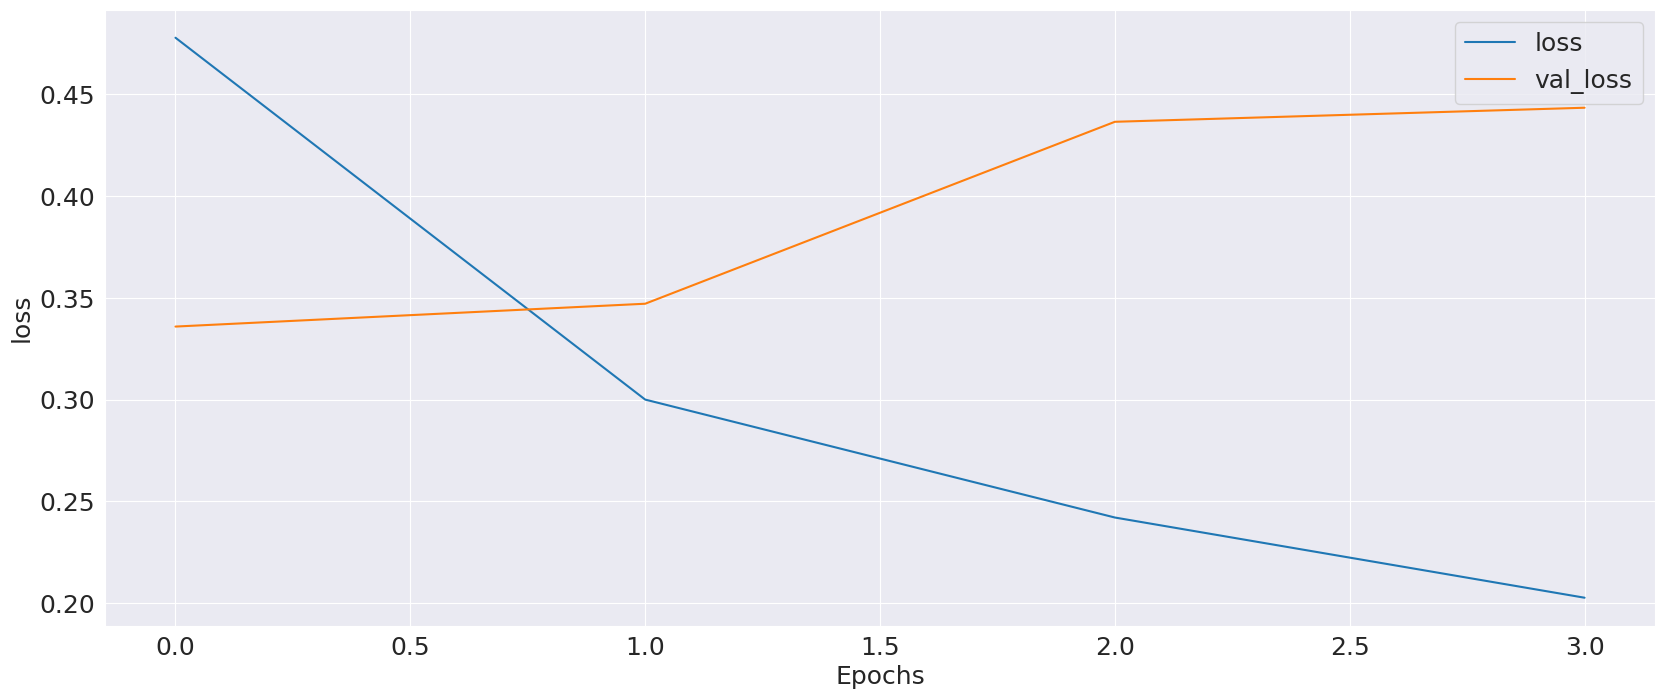

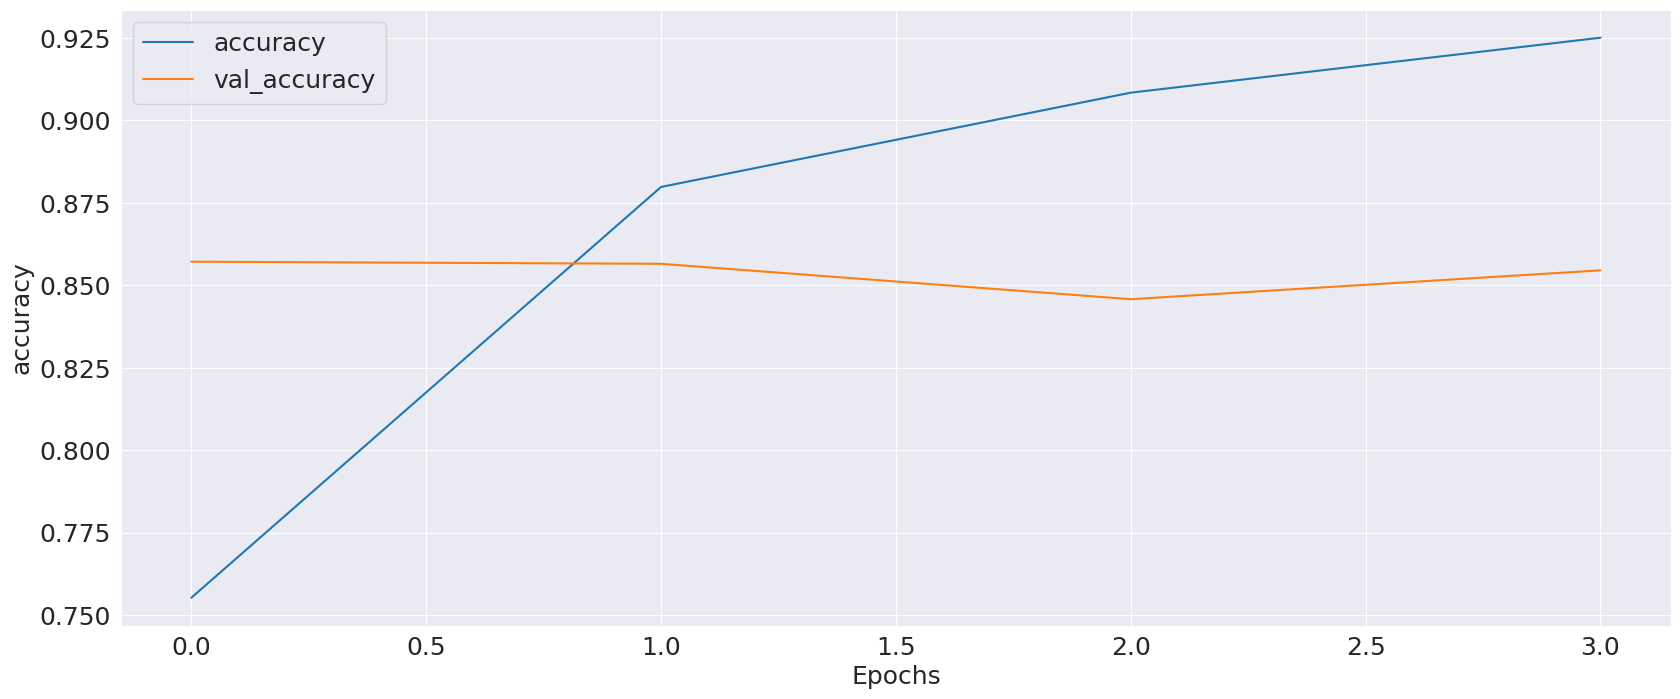

In [25]:
from utils.plot_utils import plot_history_metrics, get_classification_report 
plot_history_metrics(history, ['loss', 'accuracy'])

492/492 [==============================] - 2s 3ms/step


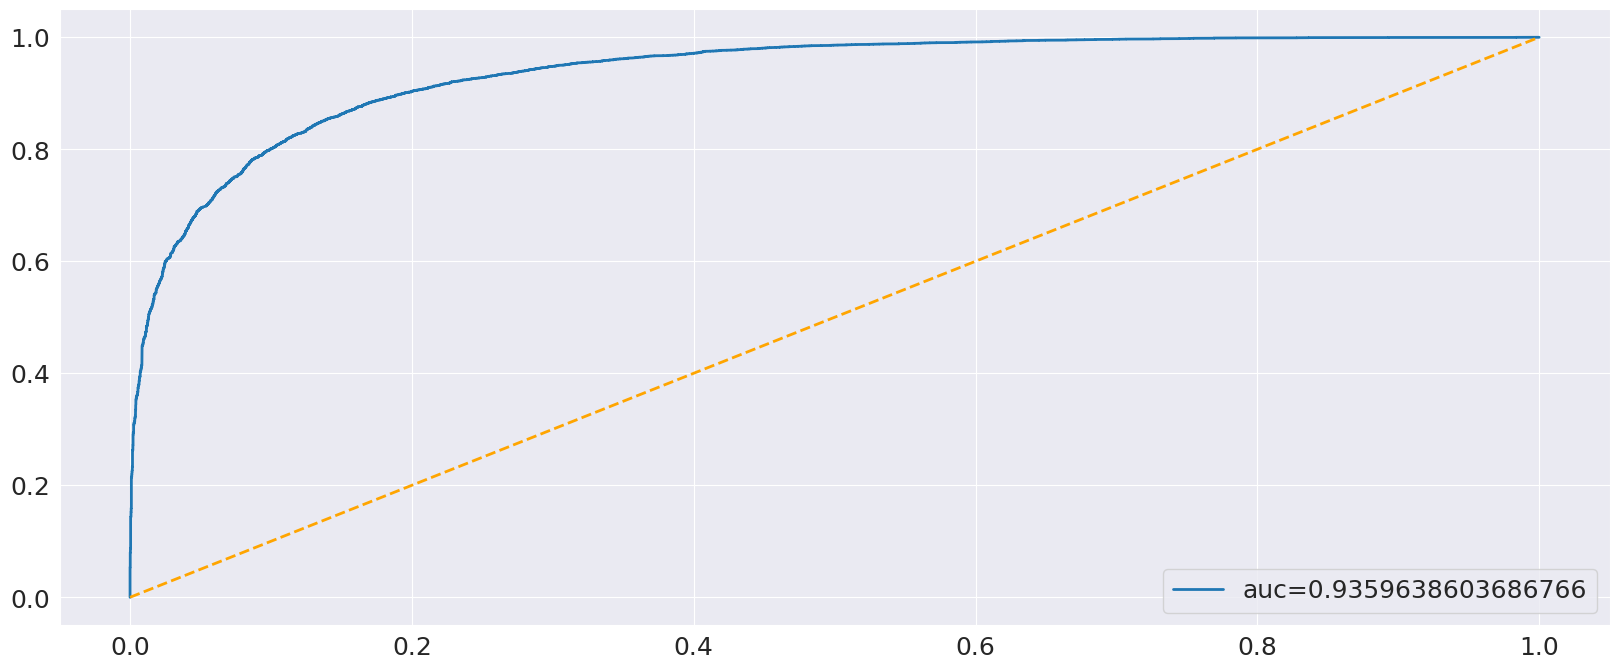

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      7496
           1       0.93      0.70      0.80      8220

    accuracy                           0.82     15716
   macro avg       0.84      0.82      0.82     15716
weighted avg       0.84      0.82      0.82     15716



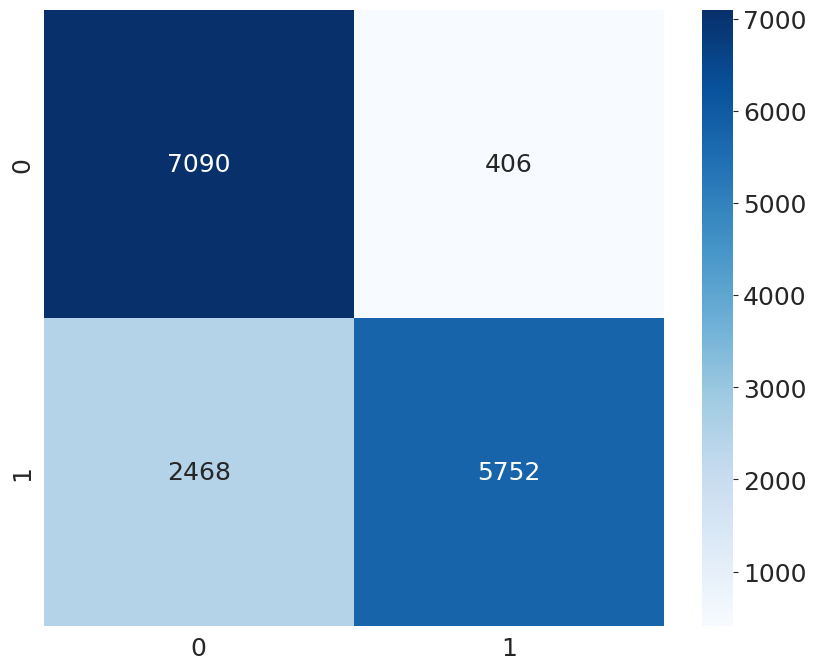

In [26]:
get_classification_report(transformer_model, test_data, test_label)

### Results
The model isn't generalizing all to good, which can be seen by the increasing validation loss, which is an indicator for overfitting. To combat this we could lower the vocabulary size, decrease sequence length or even try pre-trained embeddings like GloVe.

## Using pre-trained word embeddings (GloVe)

We will use [GloVe](https://github.com/stanfordnlp/GloVe) pre-trained embeddings which were published by the Stanford University. The 100d Model is available on [Kaggle](https://www.kaggle.com/datasets/anindya2906/glove6b). The file `glove.6B.100d.txt` needs to be placed in the `embeddings` folder so that the path `embeddings/glove.6B.100d.txt` is available.

In [43]:
from utils.file_utils import read_embeddings
filepath = './embeddings/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = read_embeddings(filepath)

### Checking the encoding of a random word

In [45]:
test_word = 'hello'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f'Vector for {test_word}:\n\n{test_vector}')

Vector for hello:

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.15636   -0.20334
  0.

All vectors have 100 dimensions to capture the semenatics of a word.

In [46]:
print(f'Vector shape: {test_vector.shape}')

Vector shape: (100,)


### Encode our vocabulary with GloVe Vectors

In [47]:
EMBEDDING_MATRIX = np.zeros((MAX_FEATURES, SEQ_LENGTH))

for i, word in np.ndenumerate(vocabulary):
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[i] = embedding_vector

In [51]:
glove_model = create_model(EMBEDDING_MATRIX)

TypeError: Exception encountered when calling layer "token_and_position_embedding_3" (type TokenAndPositionEmbedding).

in user code:

    File "/tmp/ipykernel_53885/3414522621.py", line 34, in call  *
        x = self.token_emb(x)
    File "/home/x/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/x/miniconda3/envs/tf/lib/python3.9/site-packages/keras/initializers/initializers.py", line 265, in __call__
        return tf.constant(self.value, dtype=_get_dtype(dtype), shape=shape)

    TypeError: Eager execution of tf.constant with unsupported shape. Tensor [[ 0.        0.        0.       ...  0.        0.        0.      ]
     [ 0.        0.        0.       ...  0.        0.        0.      ]
     [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
     ...
     [-0.51781   0.069206 -0.092875 ... -0.40334   0.61396   0.26236 ]
     [-0.16668   0.039342  0.26625  ... -0.22897   0.39733  -0.087264]
     [-0.21966  -0.59548   0.27109  ... -0.47255   0.016739  0.49988 ]] (converted from [[ 0.          0.          0.         ...  0.          0.
       0.        ]
     [ 0.          0.          0.         ...  0.          0.
       0.        ]
     [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
       0.27061999]
     ...
     [-0.51780999  0.069206   -0.092875   ... -0.40334001  0.61396003
       0.26236001]
     [-0.16667999  0.039342    0.26625001 ... -0.22897001  0.39732999
      -0.087264  ]
     [-0.21966    -0.59548002  0.27109    ... -0.47255     0.016739
       0.49987999]]) has 3000000 elements, but got `shape` (30000, 16) with 480000 elements).


Call arguments received by layer "token_and_position_embedding_3" (type TokenAndPositionEmbedding):
  • x=tf.Tensor(shape=(None, 100), dtype=float32)